# Stereo 

A script for implementing stereo algorithms 1, 2, and 3 from the lecture slides

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
import numpy as np
from tqdm import tqdm

In [2]:
# RGB to gray
def rgb2gray(rgb):
    return np.dot(rgb[..., :3], [0.299, 0.587, 0.114])

In [84]:
def stereo1(img1, img2, dispRange):
    # Load in both images, assumed to be RGBA 8bit per channel images    
    h, w = img1.shape  # assume that both images are same size   
    
    left = img1.copy()
    right = img2.copy()
    
    # Depth (or disparity) map
    dispMap = np.zeros((h, w), np.int8)
      
    for y in range(h):      
        print(".", end="", flush=True)  # let the user know that something is happening (slowly!)
        
        for x in range(w):
            best_offset = 0
            prev_d = None
            
            for offset in range(-dispRange, dispRange+1):               
                maxc = max(0, x + offset)
                maxc = min(maxc, w-1)
                
                d = abs(int(left[y, x]) - int(right[y, maxc]))              
                            
                
                # if this value is smaller than the previous ssd at this block
                # then it's theoretically a closer match. Store this value against
                # this block..
                if prev_d == None or d < prev_d:
                    prev_d = d
                    best_offset = abs(offset)
                            
            # set depth output for this x,y location to the best match
            dispMap[y, x] = best_offset
                                
    return dispMap

In [65]:
def map_value(img):
    #print(np.min(img))
    return (((img - np.min(img)) / (np.max(img) - np.min(img))) * 255).astype(np.uint8)

def metric_SSD(block_l, block_r):
    return np.sum(np.square(block_l - block_r))


def stereo2(img1, img2, dispRange, windowSize):
    pad_size = windowSize // 2
    img_left = np.pad(img1, ((pad_size, pad_size), (pad_size, pad_size)), 'constant', constant_values=((0, 0), (0, 0)))
    img_right = np.pad(img2, ((pad_size, pad_size), (pad_size, pad_size)), 'constant', constant_values=((0, 0), (0, 0)))
    result = np.empty([img1.shape[0], img1.shape[1]])
    print(img_left.shape, img_right.shape)
    for i in range(0, img1.shape[0]):
        print(".", end="", flush=True)
        for j in range(0, img1.shape[1]):
            # print "j: ", j
            filter = img_left[i:i+windowSize, j:j+windowSize]
            start = np.amax([0, j-dispRange])
            best_SSD = 99999999
            best_x = start
            end = np.amin([img1.shape[1], j+dispRange])
            # end = np.amin([img_l.shape[1], start+range_size*2])
            #
            # print "start: ", start
            # print "end: ", end
            # filter_result = np.empty(end-start)
            for k in range(start, end):
                SSD = metric_SSD(filter, img_right[i:i + windowSize, k:k + windowSize])
                if SSD < best_SSD:
                    best_SSD = SSD
                    best_x = k
            result[i][j] = np.absolute(j - best_x)
            # print j, best_x, j - best_x, best_SSD

    return map_value(result)

In [7]:
def stereo3(img1, img2, dispRange, windowSize, lamda):
    raise NotImplementedError

### Experimental settings

In [21]:
f1 = "sawtooth/im2.jpg"
f2 = "sawtooth/im6.jpg"

img1 = rgb2gray(plt.imread(f1)).astype(np.uint8)
img2 = rgb2gray(plt.imread(f2)).astype(np.uint8)

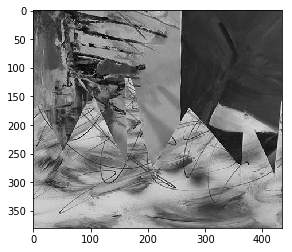

In [9]:
plt.imshow(img1, cmap='gray')

### Stereo 1

In [85]:
dispRange = 15

dispMap = stereo1(img1, img2, dispRange)

............................................................................................................................................................................................................................................................................................................................................................................................

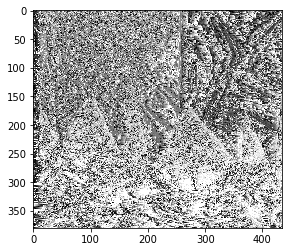

In [86]:
plt.imshow(dispMap, cmap='gray')

In [87]:
dispRange = 15

dispMap = stereo1(img2, img1, dispRange)

............................................................................................................................................................................................................................................................................................................................................................................................

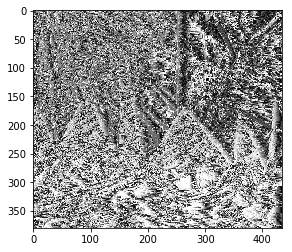

In [88]:
plt.imshow(dispMap, cmap='gray')

### Stereo 2

In [60]:
windowSize = 7
dispRange = 30

dispMap = stereo2(img1, img2, dispRange, windowSize)

(386, 440) (386, 440)
............................................................................................................................................................................................................................................................................................................................................................................................0.0


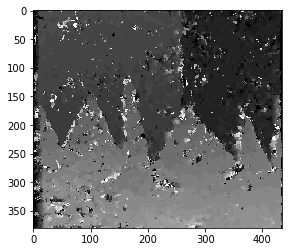

In [61]:
plt.imshow(dispMap, cmap='gray')

In [62]:
windowSize = 7
dispRange = 30

dispMap = stereo2(img1, img2, dispRange, windowSize)

(386, 440) (386, 440)
............................................................................................................................................................................................................................................................................................................................................................................................0.0


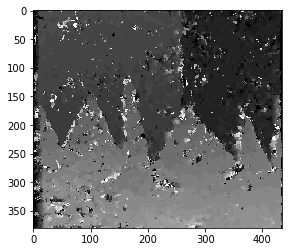

In [63]:
plt.imshow(dispMap, cmap='gray')

### Stereo 3

In [89]:
left_img = img1.copy()
right_img = img2.copy()

x,y=left_img.shape
v,w=right_img.shape
#print "left image dimension",x,y
#print "right image dimension",v,w

DisparityMatrix_left=np.zeros(left_img.shape, np.uint8)
DisparityMatrix_right=np.zeros(right_img.shape, np.uint8)
#DisparityMatrix_left.astype(int)
#DisparityMatrix_right.astype(int)

#Disparity Computation for Left Image

OcclusionCost = 20 #(You can adjust this, depending on how much threshold you want to give for noise)

#For Dynamic Programming you have build a cost matrix. Its dimension will be numcols x numcols
for all_rows in range (0,x):
    #print all_rows
    CostMatrix=np.zeros((y,y))
    
    DirectionMatrix = np.zeros((y,y))  #(This is important in Dynamic Programming. You need to know which direction you need traverse)
    
    #We first populate the first row and column values of Cost Matrix
    
    for i in range(0,y):
        CostMatrix[i,0] = i*OcclusionCost
        CostMatrix[0,i] = i*OcclusionCost
        
        #print np.abs((left_img[all_rows,0]-right_img[all_rows,0]))
    
    for i in range(0,y):
        for j in range (0,y):
            min1=CostMatrix[i-1,j-1]+np.abs((int(left_img[all_rows,i])-int(right_img[all_rows,j])))
            min2=CostMatrix[i-1,j]+OcclusionCost
            min3=CostMatrix[i,j-1]+OcclusionCost
            cmin=np.min((min1,min2,min3))
            
            CostMatrix[i,j]=cmin
            if min1==cmin:
                DirectionMatrix[i,j]=1
            if min2==cmin:
                DirectionMatrix[i,j]=2
            if min3==cmin:
                DirectionMatrix[i,j]=3
                   
        #print DirectionMatrix
        # Now, its time to populate the whole Cost Matrix and DirectionMatrix
        
        # Use the pseudocode from "A Maximum likelihood Stereo Algorithm" paper given as reference
        p=y-1
        q=y-1
        
        #print q
        #print p

    while ((p!=0) and (q!=0)):
        #print "Values for direction matrix"
        #print(DirectionMatrix[p,q])
        if DirectionMatrix[p,q]==1:
            #print("inside 1")
            DisparityMatrix_left[all_rows,p]=np.abs(p-q)
            DisparityMatrix_right[all_rows,q]=np.abs(p-q)
            p=p-1
            q=q-1
            
        elif DirectionMatrix[p,q]==2:
            #print("inside 2")
            p=p-1
            # DisparityMatrix_left[all_rows,p]=np.abs(p-q)
            
           
        elif DirectionMatrix[p,q]==3:
            #print("inside 3")
            q=q-1
            # DisparityMatrix_right[all_rows,q]=np.abs(p-q)
           
            
    
    #print "Left"
    #print DisparityMatrix_left
    #print "Right"
    #print DisparityMatrix_right
    
print(DisparityMatrix_left)
print("###################")
print(DisparityMatrix_right)

[[ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  4  4  3]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  4  4  4]
 [ 0  0  0 ... 18 17 13]
 [ 0  0  0 ... 17 17 17]]
###################
[[ 0  8  8 ...  0  0  0]
 [ 0  9  9 ...  0  0  0]
 [ 0  9  9 ...  0  0  0]
 ...
 [ 0 18 18 ...  0  0  0]
 [ 0 19 19 ...  0  0  0]
 [ 0 26 26 ...  0  0  0]]


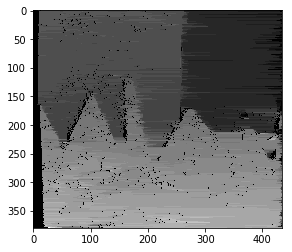

In [90]:
plt.imshow(DisparityMatrix_left, cmap='gray')

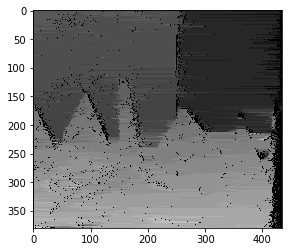

In [91]:
plt.imshow(DisparityMatrix_right, cmap='gray')